# Exploratory data analysis

## Imports

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
from gensim.models import Word2Vec
from wordcloud import WordCloud, ImageColorGenerator
from PIL import Image
import pyLDAvis.gensim
import pyLDAvis
import gensim.corpora as corpora
from pprint import pprint
import gensim

import warnings
warnings.filterwarnings('ignore')

## Load the data

Lists that have been stored in CSV aren't automatically parsed by `pandas`. Thus this small function converts a string in the form `'{'banana', 'orange', 'tangerine'}'` in a Python list containing the same elements

In [2]:
def string_to_list(column):
    return [element.strip(" ") for element in column.strip("{}").replace("'", "").split(", ")]

Simply use `read_csv` to import the data. We ignore the first column since we do not need these repeating ids. We can then apply our `string_to_list` function to the list of hashtags

In [3]:
tiktoks = pd.read_csv("tiktoks_500.csv", usecols=range(1,8), parse_dates=["date"])
tiktoks.hashtags = tiktoks.hashtags.apply(string_to_list)
tiktoks.head(5)

,video_id,hashtags,date,user_id,n_likes,n_comments,n_shared
0,-4937456930930190897,"[biden2020, straya, bidenharris2020, aussie]",2020-11-07 01:51:07,-9074424973670462894,8300000,82700,238100
1,2837885220496618646,"[foryou, viral, biden2020, tiktok, fürdich, bi...",2020-11-06 18:11:03,7802184149743201610,7200000,154800,536900
2,-7616690630605139661,"[foryou, fyp, foryoupage, biden2020]",2020-10-19 18:41:40,8599333060831776201,5000000,104800,400500
3,-1485617807006866345,"[viral, biden2020, trump2020, repost, parati, ...",2020-06-16 22:41:10,-2163225678390988754,5000000,136100,356100
4,8847244246175840872,[biden2020],2020-10-31 23:04:55,8834409548135308984,4600000,68700,218100


## Visualitions

We first create a list containing all the hashtags we used to collect the data.

Then we create the DataFrame `tiktoks_exploded` that contains one entry for each hashtags. This means that if a row had hashtags `['Biden2020', 'bidenharris2020']`, the exploded version will transform it in two distinct rows, each with a single hashtag

In [4]:
queried_hashtags = ["Biden2020", "Trump2020", "biden", "trump", "election2020", "2020election", "donaldtrump", "joebiden", "maga", "trumpout",
                    "democrat", "republican", "trumpvsbiden", "bidenvstrump", "voteblue", "votered"]
tiktoks_exploded = tiktoks.explode("hashtags")

Display the distribution of publications of each of the queried hashtags. Each bin represents a period of 10 days.

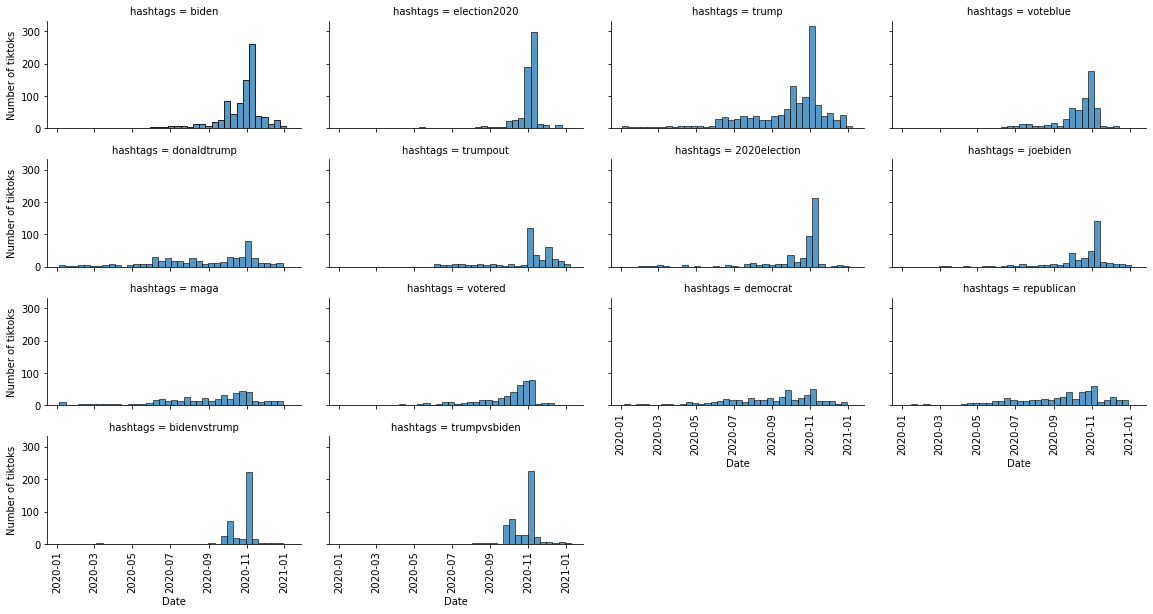

In [5]:
g = sns.FacetGrid(tiktoks_exploded.query("hashtags in @queried_hashtags"), col="hashtags", col_wrap = 4, sharex = True, sharey=True, height = 2, aspect=2)
g.map_dataframe(sns.histplot, x="date", binwidth=10)
g.set_axis_labels("Date", "Number of tiktoks")
g.set_xticklabels(rotation=90)

Display the top 20 most used hashtags in our dataset

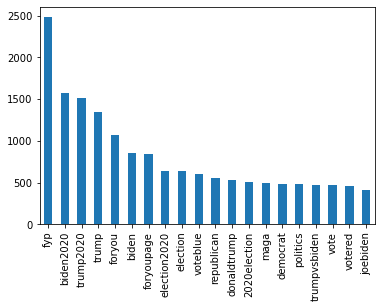

In [6]:
top_20 = tiktoks_exploded.hashtags.value_counts()[:20].plot(kind="bar")

# Looking at the distribution of hashtags overtime

Creating a new column to store only date of the video (to groupby videos based on date)

In [7]:
tiktoks_exploded['only_date'] = pd.to_datetime(tiktoks_exploded['date']).dt.date.astype(dtype='datetime64[ms]')

Grouping the tiktoks based on date and then hastags to the hashtag count perday

In [8]:
tiktoks_hash_grouped = tiktoks_exploded.groupby(["only_date","hashtags"]).size().to_frame(name = 'count').reset_index()
tiktoks_hash_grouped

,only_date,hashtags,count
0,2020-01-03,2020,1
1,2020-01-03,america,1
2,2020-01-03,arianagrande,1
3,2020-01-03,donaldtrump,1
4,2020-01-03,foryou,1
...,...,...,...
19339,2020-12-31,viratkohli,1
19340,2020-12-31,whatilearned,1
19341,2020-12-31,whatwouldyoudo,1
19342,2020-12-31,wordsofwisdom,1


As there are many hashtags that have occured very less frequent of time compared to others, we remove all the hashtags that have occured less than 25 times

In [9]:
minimum_occurances = 150
hashtag_value_counts = tiktoks_hash_grouped["hashtags"].value_counts()
hash_list = hashtag_value_counts[hashtag_value_counts > minimum_occurances].index.tolist()

# hash_list contains the hashtags that have been used more than *minimum_occurances* number of times

In [10]:
tiktok_ht_min_occ = tiktoks_hash_grouped[tiktoks_hash_grouped['hashtags'].isin(hash_list)]

Creating a new dataframe with each hashtag as column and value as the count of hashtag occurance on that day

In [11]:
perday_hashtag_count = tiktok_ht_min_occ.pivot_table(values='count', index="only_date", columns='hashtags', aggfunc='first', fill_value=0)

In [12]:
plt.rcParams["figure.figsize"] = (10,30)

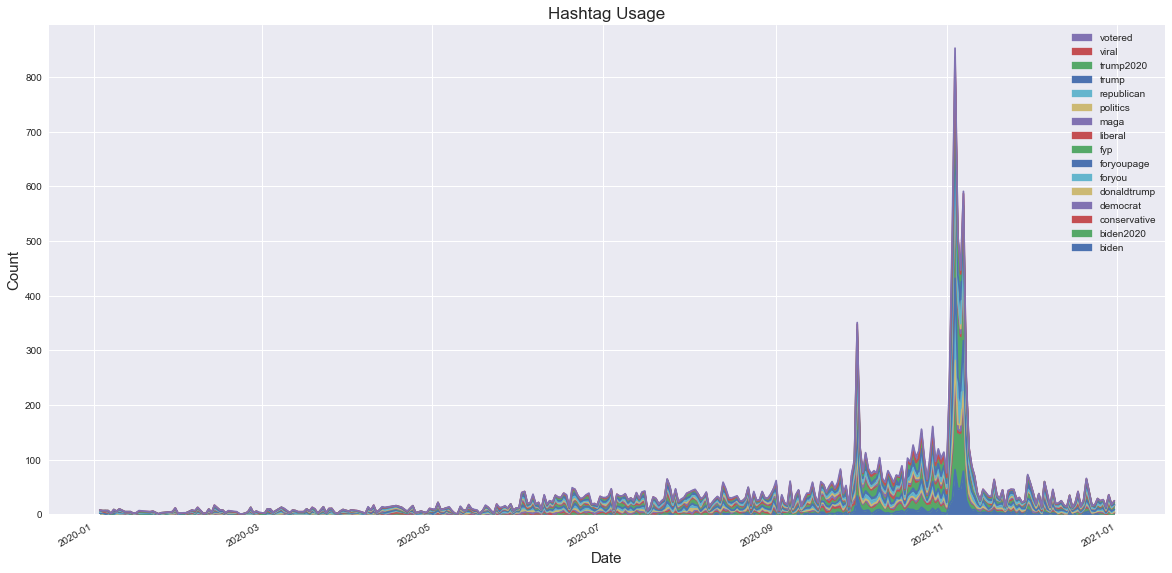

In [13]:
plt.style.use('seaborn')
perday_hashtag_count.plot.area(figsize=(20, 10))
plt.xlabel('Date', fontsize=15)
plt.ylabel('Count', fontsize=15)
plt.title('Hashtag Usage', fontsize=17)

ax = plt.gca()
handles, labels = ax.get_legend_handles_labels()
labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0], reverse=True))
ax.legend(handles, labels)
plt.show()

Similar plot using Seaborn

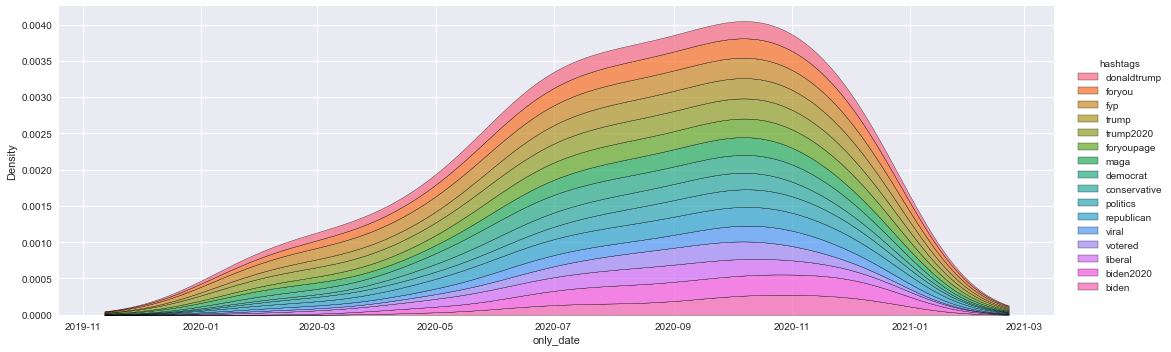

In [14]:
sns.displot(tiktok_ht_min_occ, x="only_date", hue="hashtags", kind="kde", multiple="stack", aspect = 3)

##### Using the area occupied by each hashtag in the plot we can how has the usage shifted over time

1. We should make small plots dividing over time to analyse easily

# Matching TikToks with events

Top 10 days when people posted tiktoks about the elections:

In [15]:
tiktoks["only_date"] = pd.to_datetime(tiktoks['date']).dt.date.astype(dtype='datetime64[ms]')
tiktoks.only_date.value_counts()[:10]

2020-11-04    395
2020-11-07    278
2020-11-05    260
2020-11-03    243
2020-11-06    201
2020-09-30    145
2020-11-08    127
2020-11-02    103
2020-10-27     58
2020-10-23     58
Name: only_date, dtype: int64

* Nov. 2-8 : Election Day was on the 3rd. With all the fuss about the count delays, recounts, fraud claims, etc... the hype lived up until the eighth
* Sep. 30 : The infamous first debate between Biden and Trump that ended up being a shitshow
* Oct. 17 : The Senate confirms ACM to the supreme court one week before the election lol
* Oct. 23 : Second debate between Biden and Trump

# Cooccurances

Creates a co-occurance matrix using pandas

In [16]:
lst = list(tiktoks.hashtags)
u = (pd.get_dummies(pd.DataFrame(lst), prefix='', prefix_sep='')
       .groupby(level=0, axis=1)
       .sum())

v = u.T.dot(u)
v.values[(np.r_[:len(v)], ) * 2] = 0

In [17]:
def plot_co_occurance_matrix(matrix, threshold, figsize):
    fig, axes = plt.subplots(figsize=figsize)
    top_100_indices = matrix[matrix.sum(axis=1) > threshold].index
    print(len(top_100_indices))
    sns.heatmap(matrix[matrix.sum(axis=1) > threshold][list(top_100_indices)], cmap="flare")

We plot the co_occurance matrix only using the hashtags with more than 600 occurances

* We observe that (biden, trump) and (biden2020, trump2020) have the most co-occurances. Could it suggest that most TikToks are about the elections in general and not rooting for a particular party ?
* Biden appears a lot with `fyp`, whereas Trump barely does. Does it show that Biden supporters are the more experienced TikTok's user and know that platform better ? Which would also show Biden supporters are the younger generation.
* Without surprise, (Trump, Trump2020) and (Biden, Biden2020) appear often together.
* blm doesn't seem more corrolated to biden than trump

58


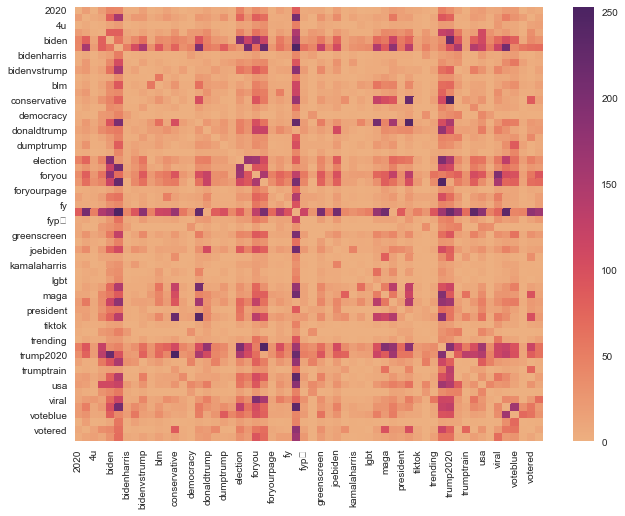

In [105]:
plot_co_occurance_matrix(v, 600, (10.5,8))

Let us now try to get a 2D embedding of each word from this co-occurance matrix by using the Truncated SVD from SkLearn

In [78]:
tsvd = TruncatedSVD(n_components=2)
v_transformed = tsvd.fit_transform(v)

We only keep the embeddings of the hashtags with more than 600 occurances

In [98]:
top_600_indices = list(v[v.sum(axis=1) > 600].index)
v_transformed_reduced = v_transformed[v.sum(axis=1) > 600]

Plot the embeddings

In [99]:
def plot_embeddings(words, vec, figsize):
    fig, axes = plt.subplots(figsize=(10,10))
    for i,word in enumerate(words):
        x = vec[i][0]
        y = vec[i][1]
        plt.scatter(x, y, marker='x', color='red')
        plt.text(x, y+0.01, word, fontsize=9)
    plt.show()

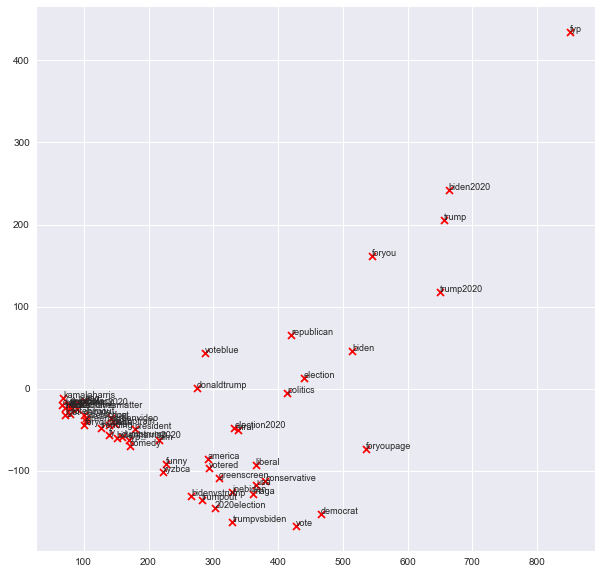

In [100]:
plot_embeddings(top_600_indices, v_transformed_reduced, (10,10))

In [101]:
model = Word2Vec(sentences=tiktoks.hashtags, size=2, window=3, min_count=1, workers=4)
vecs = []
for hashtag in top_600_indices:
    vecs.append(model.wv[hashtag])

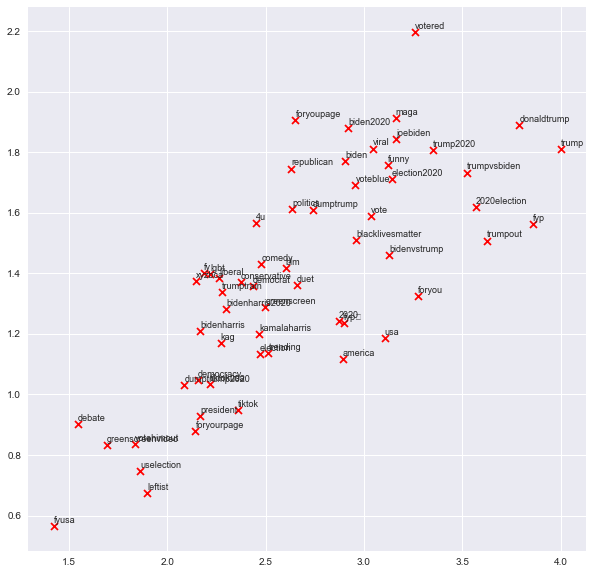

In [102]:
plot_embeddings(top_600_indices, vecs, (10,10))

Let's try to plot the heatmap of the word embeddings using the cosine similarity

In [103]:
vec_length = 10
model = Word2Vec(sentences=tiktoks.hashtags, size=vec_length, window=2, min_count=1, workers=4)
vecs = np.empty((len(top_600_indices),vec_length))
for i in range(len(top_600_indices)):
    vecs[i] = model.wv[top_600_indices[i]]

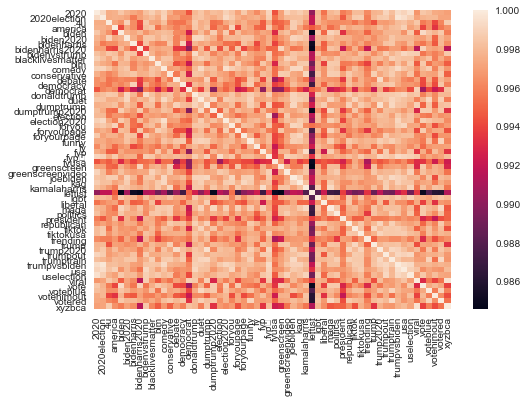

In [104]:
ax = sns.heatmap(cosine_similarity(vecs), xticklabels=top_600_indices, yticklabels=top_600_indices)

# User Clustering using hashtags

Create a user profile based on hashtags i.e create a bag of hashtag vector.

First, we select the hashtags with minimum occurances

In [27]:
tiktoks_exploded_ht_min = tiktoks_exploded[tiktoks_exploded['hashtags'].isin(hash_list)]

In [ ]:
tiktok_users = tiktoks_exploded_ht_min.groupby(["user_id","hashtags"]).size().to_frame(name = 'count').reset_index()
tiktok_users

In [ ]:
user_hashtag_vec = tiktok_users.pivot_table(values='count', index="user_id", columns='hashtags', aggfunc='first', fill_value=0)

In [ ]:
user_hashtag_vec

In [ ]:
# lost the link to source website where I (Ravi) has taken the code from

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
dist = 1 - cosine_similarity(user_hashtag_vec)

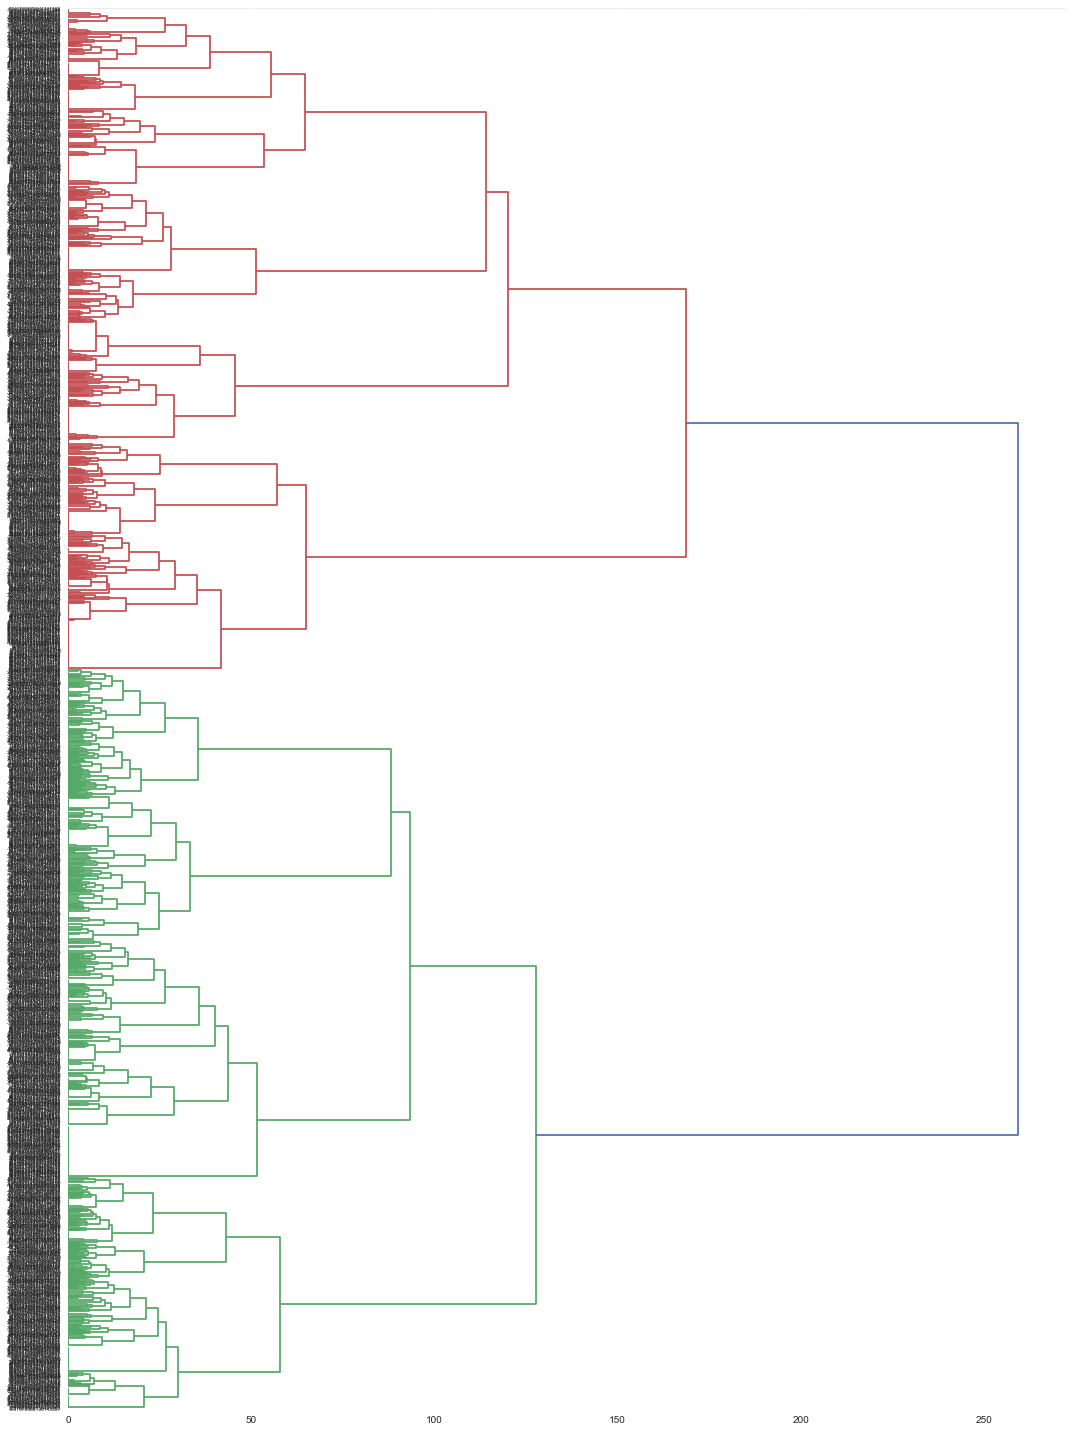

In [41]:
from scipy.cluster.hierarchy import ward, dendrogram

linkage_matrix = ward(dist) #define the linkage_matrix using ward clustering pre-computed distances

fig, ax = plt.subplots(figsize=(15, 20)) # set size
ax = dendrogram(linkage_matrix, orientation="right", labels=user_hashtag_vec.index.tolist());

plt.tick_params(\
    axis= 'x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off')

plt.tight_layout() #show plot with tight layout

# Video Clustering using hashtags

## Word Cloud of Hashtags

In [92]:
long_string = ','.join((list([a for b in tiktoks.hashtags.tolist() for a in b])))

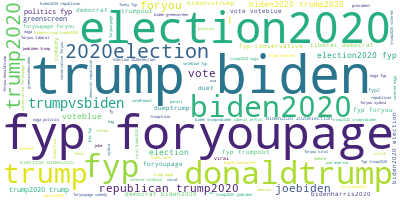

In [93]:
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

### Word Cloud of Hashtags in USA map style.

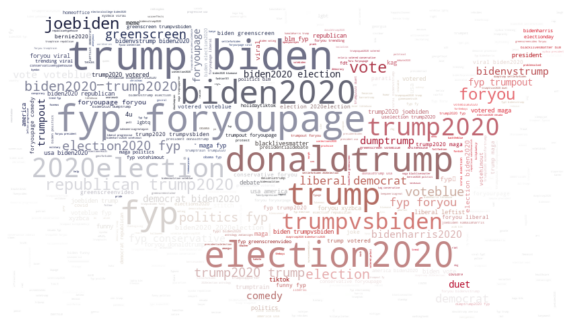

In [94]:
mask = np.array(Image.open("img/us.jpg"))
wordcloud_usa = WordCloud(background_color="white", mode="RGBA", max_words=1000, mask=mask).generate(long_string)

# create coloring from image
image_colors = ImageColorGenerator(mask)
plt.figure(figsize=[10,10])
plt.imshow(wordcloud_usa.recolor(color_func=image_colors), interpolation="bilinear")
plt.axis("off")
plt.show()

## Topic Modelling of videos

In [95]:
data_words = tiktoks.hashtags.values.tolist()

# Create Dictionary
id2word = corpora.Dictionary(data_words)

# Create Corpus
texts = data_words

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

We shall remove those hashtags that have frequency less than the minimum frequency

In [96]:
ids=[id2word.token2id[hash_list[i]] for i in range(len(hash_list))]
id2word.filter_tokens(bad_ids=ids)

In [97]:
corpus = [id2word.doc2bow(text) for text in data_words]

In [62]:
from gensim.models.coherencemodel import CoherenceModel

scores = pd.DataFrame(columns=["c_v", "u_mass"])


for n_topics in range(2, 20, 1):
    print("Number of topics : ", n_topics)
    model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=n_topics)
    # Compute Coherence Score
    coherence_model_lda = CoherenceModel(model=model, texts=texts, dictionary=id2word, coherence='c_v')
    coherence_model_lda_u_mass = CoherenceModel(model=model, corpus=corpus, dictionary=id2word, coherence='u_mass')
    coherence_lda = coherence_model_lda.get_coherence()
    coherence_lda_u_mass = coherence_model_lda_u_mass.get_coherence() 
    print('Coherence Score c_v: ', coherence_lda)
    print('Coherence Score u_mass: ', coherence_lda_u_mass)
    scores.loc[n_topics] = {'c_v' : coherence_lda, 'u_mass': coherence_lda_u_mass}

Number of topics :  2
Coherence Score c_v:  0.18475357161353362
Coherence Score u_mass:  -3.6763191718651878
Number of topics :  3
Coherence Score c_v:  0.18482790889589243
Coherence Score u_mass:  -4.148026437397418
Number of topics :  4
Coherence Score c_v:  0.19803663842923858
Coherence Score u_mass:  -4.123316035262775
Number of topics :  5
Coherence Score c_v:  0.19338719008663804
Coherence Score u_mass:  -4.094029103195377
Number of topics :  6
Coherence Score c_v:  0.19673716518780604
Coherence Score u_mass:  -4.245290243083436
Number of topics :  7
Coherence Score c_v:  0.21472914071740137
Coherence Score u_mass:  -4.567767967436653
Number of topics :  8
Coherence Score c_v:  0.23443860397095095
Coherence Score u_mass:  -4.357439342738684
Number of topics :  9
Coherence Score c_v:  0.23127730521044246
Coherence Score u_mass:  -4.63281006392641
Number of topics :  10
Coherence Score c_v:  0.23741423543696913
Coherence Score u_mass:  -4.943467022343925
Number of topics :  11
Cohe

In [67]:
copy_score = scores.copy()
copy_score = (copy_score-copy_score.mean())/copy_score.std()

Text(0, 0.5, 'Coherence Score (C_v)')

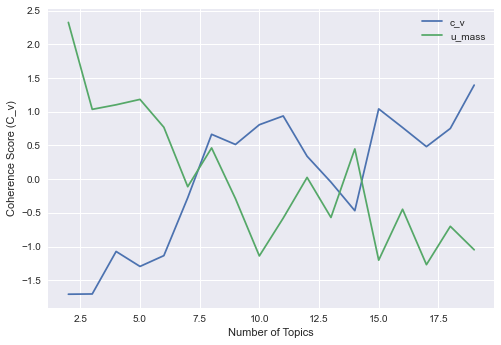

In [68]:
ax = copy_score.reset_index().plot(x = 'index', y = ['c_v', 'u_mass'], sharey=False)
ax.set_xlabel("Number of Topics")
ax.set_ylabel("Coherence Score (C_v)")

In [71]:
# number of topics
num_topics = 10

# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)

# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.024*"voteblue" + 0.020*"vote" + 0.014*"joebiden" + 0.013*"duet" + '
  '0.013*"greenscreen" + 0.012*"usa" + 0.012*"dumptrump" + 0.012*"funny" + '
  '0.012*"america" + 0.010*"2020"'),
 (1,
  '0.044*"joebiden" + 0.017*"vote" + 0.016*"comedy" + 0.016*"fypシ" + '
  '0.014*"2020election" + 0.013*"funny" + 0.012*"kamalaharris" + '
  '0.012*"voteblue" + 0.011*"election2020" + 0.011*"election"'),
 (2,
  '0.068*"bidenvstrump" + 0.024*"trumpvsbiden" + 0.014*"greenscreen" + '
  '0.014*"voteblue" + 0.012*"usa" + 0.011*"joebiden" + 0.011*"2020election" + '
  '0.009*"fy" + 0.008*"election" + 0.007*"election2020"'),
 (3,
  '0.065*"election2020" + 0.033*"election" + 0.022*"voteblue" + '
  '0.019*"trumpvsbiden" + 0.019*"joebiden" + 0.016*"usa" + 0.014*"vote" + '
  '0.010*"trumpout" + 0.009*"bidenharris2020" + 0.008*"funny"'),
 (4,
  '0.022*"usa" + 0.018*"election" + 0.017*"voteblue" + 0.016*"vote" + '
  '0.016*"bidenvstrump" + 0.014*"america" + 0.014*"blm" + 0.013*"trumpvsbiden" '
  '+ 0.012*"t

In [73]:
# Visualize the topics
pyLDAvis.enable_notebook()

LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)


LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5     -0.042475 -0.003185       1        1  15.106205
6      0.001609 -0.012904       2        1  12.566425
7     -0.042446 -0.054296       3        1  11.518016
3     -0.069715  0.063218       4        1  10.330384
9      0.005883 -0.083324       5        1  10.211547
1      0.022093  0.063412       6        1   8.790926
2      0.151567  0.037526       7        1   8.458170
4      0.019961 -0.022582       8        1   7.784908
8     -0.058253  0.061438       9        1   7.740715
0      0.011776 -0.049302      10        1   7.492703, topic_info=             Term        Freq       Total Category  logprob  loglift
453  bidenvstrump  318.000000  318.000000  Default  30.0000  30.0000
3    election2020  519.000000  519.000000  Default  29.0000  29.0000
41       election  516.000000  516.000000  Default  28.0000  28.0000
46       joebiden  334.000000  334.000000  Default  27.0000  27.0000
12            blm  193.000000  193.000000  Default  26.0000  26.0000
..            ...         ...         ...      ...      ...      ...
3    election2020   12.370194  519.616820  Topic10  -4.9580  -1.1466
82         xyzbca    8.776843  168.735269  Topic10  -5.3011  -0.3650
743    trumptrain    7.785579  121.108082  Topic10  -5.4210  -0.1532
66     votehimout    6.204713   88.257937  Topic10  -5.6480  -0.0637
31   2020election    6.204857  406.178487  Topic10  -5.6479  -1.5902

[787 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
67        1  0.187547         2020
67        2  0.059674         2020
67        3  0.068199         2020
67        4  0.144923         2020
67        5  0.144923         2020
...     ...       ...          ...
2302      7  0.054809  zodiacsigns
2302      8  0.054809  zodiacsigns
4739      2  0.325403      zukunft
4739      8  0.650805      zukunft
2790      8  0.878484          👁👄👁

[1661 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 7, 8, 4, 10, 2, 3, 5, 9, 1])

Trying to reproduce https://towardsdatascience.com/how-to-cluster-similar-sentences-using-tf-idf-and-graph-partitioning-in-python-5fb70627a4e0

In [109]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [111]:
tf = TfidfVectorizer(analyzer='word', ngram_range=(1, 3), min_df=0)
tfidf = tf.fit_transform([' '.join(hs) for hs in data_words])

In [114]:
from sklearn.metrics.pairwise import linear_kernel
cs = linear_kernel(tfidf, tfidf)

In [125]:
import numpy as np
from tqdm import tnrange
top_n_sentences = []

no_dups = np.array([' '.join(hs) for hs in data_words])
i = 0
top_frame = []
for c, z in zip(cs, tnrange(len(cs))):
    # Create vector of titles
    start_name = pd.Series([no_dups[i]]*15) 
    # Index of top 15 similar titles
    ix_top_n = np.argsort(-c)[0:15]
    cos_sim = pd.Series(c[ix_top_n])
    names = pd.Series(no_dups[ix_top_n])
    i +=1
    top_frame.append(pd.DataFrame([start_name, names, cos_sim]).transpose())
    
top_frame = pd.concat(top_frame)
top_frame.columns = ['title1', 'title2', 'cos_sim']
# Remove the similarities for the same sentences
top_frame['is_same'] = [bool(i==j) for i, j in zip(top_frame['title1'], top_frame['title2'])]
top_frame = top_frame[top_frame['is_same'] != True]
        
top_n_sentences.append(top_frame)

In [126]:
top_n_sentences

[                                               title1  \
 1             biden2020 straya bidenharris2020 aussie   
 2             biden2020 straya bidenharris2020 aussie   
 3             biden2020 straya bidenharris2020 aussie   
 4             biden2020 straya bidenharris2020 aussie   
 5             biden2020 straya bidenharris2020 aussie   
 ..                                                ...   
 10  walterreed whitehouse marineone trump votered ...   
 11  walterreed whitehouse marineone trump votered ...   
 12  walterreed whitehouse marineone trump votered ...   
 13  walterreed whitehouse marineone trump votered ...   
 14  walterreed whitehouse marineone trump votered ...   
 
                                                title2    cos_sim  is_same  
 1   bidenvstrump uselection2020 aussie clubpositiv...   0.179915    False  
 2                                           biden2020  0.0932435    False  
 3                                           biden2020  0.0932435    Fa

In [129]:
# We start by defining the structure of the graph
top_frame = top_n_sentences[0] #TDS articles
edges = list(zip(top_frame['title1'], top_frame['title2']))
weighted_edges = list(zip(top_frame['title1'], top_frame['title2'], top_frame['cos_sim']))
nodes = list(set(top_frame['title1']).union(set(top_frame['title2'])))

In [130]:
import networkx as nx
G = nx.Graph()
G.add_nodes_from(nodes)
G.add_edges_from(edges)
G.add_weighted_edges_from(weighted_edges)

In [131]:
# !pip install python-louvain
import community
partition = community.best_partition(G)
modularity = community.modularity(partition, G)

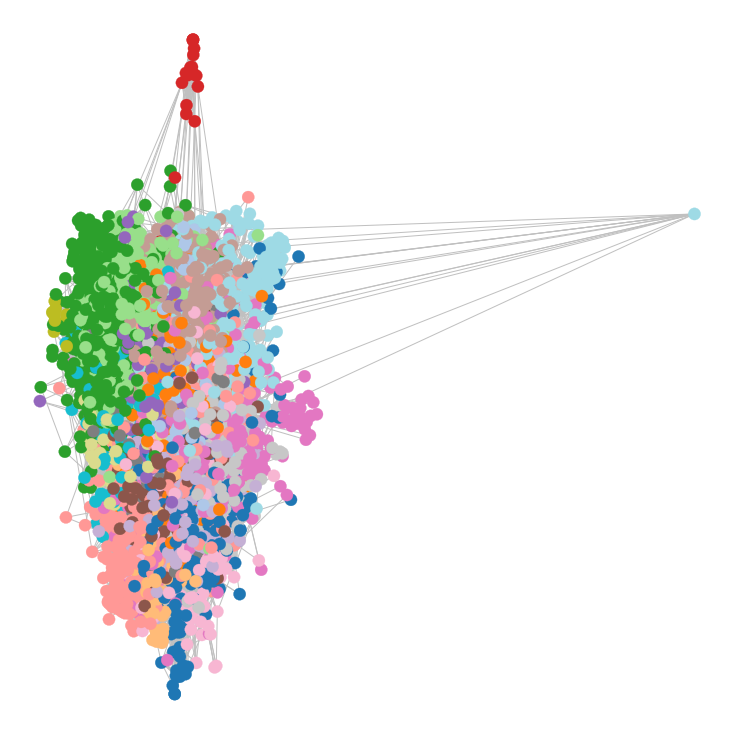

In [132]:
# Takes some time for larger graphs
import matplotlib.pyplot as plt
pos = nx.spring_layout(G, dim=2)
community_id = [partition[node] for node in G.nodes()]
fig = plt.figure(figsize=(10,10))
nx.draw(G, pos, edge_color = ['silver']*len(G.edges()), cmap=plt.cm.tab20,
        node_color=community_id, node_size=150)

In [153]:
title, cluster = [], []
for i in partition.items():
    title.append(i[0])
    cluster.append(i[1])
    
frame_clust = pd.DataFrame([pd.Series(title), pd.Series(cluster)]).transpose()
frame_clust.columns = ['Title', 'Cluster']

In [154]:
frame_clust.groupby('Cluster').count()

,Title
Cluster,
0,321
1,107
2,253
3,93
4,730
5,432
6,19
7,539
8,173


In [165]:
frame_clust['Title'] = frame_clust.apply(lambda row: " " + row['Title'] , axis=1)
frame_clust[frame_clust['Cluster']==17]['Title'].str.cat()

' biden2020 starbucks fyp inkdrawing greenscreenvideo foryou trump2020 foryoupage democrat covid19 republican covid politics foryou democrat covid19 republican fyp foryoupage republican fyp trump2020 keepamericagreat fyp trump2020 foryoupage blmriots fyp trump2020 trump2020 greenscreenvideo maga foryou coronavirus viral crafts maga trump2020 2020makeawish zyxcba fyp foryoupage crazy foryou fyp trump2020 foryoupage election2020 fyp trump2020 biden2020 2020election fyp trump2020 biden2020 biden president fyp trump2020 fyp trump2020 biden2020 coronavirus foryou fyp trump2020 fyp trump2020 votered bidenvstrump fyp trump2020 election biden2020 election2020 trump2020 biden2020 election politics trump2020 biden2020 fyp trump2020 repulican votered blacklivesmatter trumpisoverparty greenscreenvideo biden2020 elction2020 fyp trump2020 republican fyp trump2020 trump2020 houstontx foryoupage maga duck2020 trump2020 biden2020 walmartfinds lifehack cheaphack maga trump2020 corona fyp foryoupage gree